In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# base path
DATA_PATH = './drive/MyDrive/fyp-code/codes/data/emotion_classification/'
SAVED_MODEL_PATH = './drive/MyDrive/fyp-code/codes/model/emotion_classification/'

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 895 kB 56.7 MB/s 
     |████████████████████████████████| 3.3 MB 57.0 MB/s 
     |████████████████████████████████| 636 kB 55.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import re
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve, accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# check if it is running with GPU or not
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

%matplotlib inline

cuda:0


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Helper Functions

In [ ]:
# helper function to load the data
def data_handler(root, train_filename, dev_filename):
    train_data_raw = pd.read_csv(root + train_filename)
    val_data_raw = pd.read_csv(root + dev_filename)
    X_train, y_train = train_data_raw['text_cleaned'], train_data_raw['Label']
    X_val, y_val = val_data_raw['text_cleaned'], val_data_raw['Label']
    # concatenate the train and validation set text_cleaned data to get the token ids for the words
    frames = [X_train, X_val]
    X = pd.concat(frames)
    # convert from pandas dataframe to numpy arrays
    X_ = X.to_numpy()
    return X_train, y_train, X_val, y_val, X_

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            #text=text_preprocessing(sent),  # Preprocess sentence
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# tokenize data
# Specify `MAX_LEN`
MAX_LEN = 256

def create_data_loader(root,train_filename,dev_filename,batch_size=16):
    X_train, y_train, X_val, y_val, X_ = data_handler(root, train_filename, dev_filename)

    # Concatenate train data and test data
    all_texts = np.concatenate([X_train, X_val])

    # Encode our concatenated data
    encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]

    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_texts])
    #print('Max length: ', max_len)

    # Print sentence 0 and its encoded token ids
    token_ids = list(preprocessing_for_bert([X_[0]])[0].squeeze().numpy())
    #print('Original: ', X_[0])
    #print('Token IDs: ', token_ids)

    # Run function `preprocessing_for_bert` on the train set and the validation set
    print('Tokenizing data...')
    train_inputs, train_masks = preprocessing_for_bert(X_train)
    val_inputs, val_masks = preprocessing_for_bert(X_val)

    # Convert other data types to torch.Tensor
    train_labels = torch.tensor(y_train)
    val_labels = torch.tensor(y_val)

    # Create the DataLoader for our training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for our validation set
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader, y_val

## Creating the model

In [ ]:
%%time
# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 28.6 µs


In [ ]:
def initialize_model(train_dataloader, epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
# training loop
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, root_path, filepath, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")

    # initialise best valid loss
    best_valid_loss = float('inf')

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, true_list, pred_list = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

        # save best model weights
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            #torch.save(model.state_dict(), SAVED_MODEL_PATH+'toy_dataset_model.pt')
            torch.save(model.state_dict(), root_path+filepath)
    
    print("Training complete!\n\n")
    
    return true_list, pred_list

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    true_list = []
    pred_list = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        pred_list.extend(preds.tolist())
        true_list.extend(b_labels.tolist())
        #print(pred_list)
        #print(true_list)

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy, true_list, pred_list

# get the f1 score and confusion matrix
def f1_confusion_matrix(true_list, pred_list):
    labels = ['0','1']
    val_tuple = list(zip(true_list, pred_list))
    val_df = pd.DataFrame(val_tuple, columns=['true_list', 'pred_list'])
    #print(val_df.head(3))
    # get the multi-class F1-score to see the distribution of the predictions
    print('F1-Score and Confusion Matrix of the Validation Set')
    print()
    #print(classification_report(true_list, pred_list, target_names=labels, digits=4))
    print(classification_report(list(val_df['true_list']), list(val_df['pred_list']), target_names=labels, digits=4))
    print('\n')

    # confusion matrix
    #cm_sns = pd.crosstab(true_list, pred_list, rownames=['Actual'], colnames=['Predicted'])
    cm_sns = pd.crosstab(val_df['true_list'], val_df['pred_list'], rownames=['Actual'], colnames=['Predicted'])
    plt.subplots(figsize=(8,6))
    sns.heatmap(cm_sns, annot=True, fmt="d", cmap='BuGn')
    plt.show()

In [ ]:
# ROC curve and AUC value to test the value on the validation set
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# helper function to to plot the ROC curve
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%\n')
    
    # Plot ROC AUC
    print('ROC Curve')
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# for multiple graph together
def evaluate_roc_multi(probs, y_true): # takes in list of values
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """

    fpr_list = []
    tpr_list = []
    auc_value_list = []
    color_set = ['b','g','r','k']
    label_name = ['Toy Dataset', 'Short Text', 'Long Text', 'Mixed']

    for i in range(len(probs)):
        preds = probs[i][:, 1]
        fpr, tpr, _ = roc_curve(y_true[i], preds)
        auc_value = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_value_list.append(auc_value)
        # print(f'AUC: {auc_value:.4f}')
        
        # # Get accuracy over the test set
        # y_pred = np.where(preds >= 0.5, 1, 0)
        # accuracy = accuracy_score(y_true[i], y_pred)
        # print(f'Accuracy: {accuracy*100:.2f}%\n')
    
    # Plot ROC AUC
    print('ROC Curve')
    plt.rcParams["figure.figsize"] = [12,8]
    plt.title('Receiver Operating Characteristic')
    for i in range(len(probs)):
        plt.plot(fpr_list[i], tpr_list[i], color_set[i], label = f'{label_name[i]} AUC = {auc_value_list[i]:.4f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# train_data_raw = pd.read_csv(DATA_PATH + 'emotion_classification_cleaned_long_text_train.csv')
# val_data_raw = pd.read_csv(DATA_PATH + 'emotion_classification_cleaned_long_text_dev.csv')

## Training the model

### Toy Dataset

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.386775   |     -      |     -     |   13.86  
   1    |   40    |   0.022843   |     -      |     -     |   13.11  
   1    |   60    |   0.003991   |     -      |     -     |   13.42  
   1    |   80    |   0.002384   |     -      |     -     |   13.73  
   1    |   100   |   0.022342   |     -      |     -     |   14.12  
   1    |   120   |   0.002029   |     -      |     -     |   14.46  
   1    |   140   |   0.001640   |     -      |     -     |   14.26  
   1    |   160   |   0.021881   |     -      |     -     |   14.00  
   1    |   180   |   0.001687   |     -      |     -     |   13.91  
   1    |   200   |   0.021847   |     -      |     -     |   13.93  
   1    |   220   |   0.002627   |     -      |     -     |   14.06  
   1    |   226   |   0.001368   |     -      |     -     |   3.63   


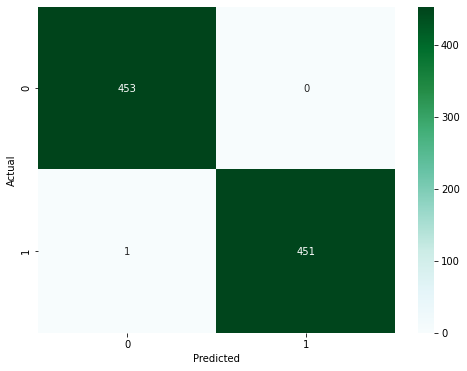

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 16

# load the data
train_loader, val_loader, y_val_toy = create_data_loader(root=DATA_PATH,
                                                     train_filename='emotion_classification_cleaned_toy_data_train.csv',
                                                     dev_filename='emotion_classification_cleaned_toy_data_dev.csv',
                                                     batch_size=batch_size)

set_seed(42)
# initalise the model
bert_classifier, optimizer, scheduler = initialize_model(train_loader,epochs=2)

# train the model
true_list, pred_list = train(model=bert_classifier,
                             root_path=SAVED_MODEL_PATH,
                             filepath='toy_dataset_bert_model.pt',
                             train_dataloader=train_loader, 
                             val_dataloader=val_loader, 
                             epochs=2, 
                             evaluation=True)

# get confusion matrix
f1_confusion_matrix(true_list, pred_list)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AUC: 1.0000
Accuracy: 99.89%

ROC Curve


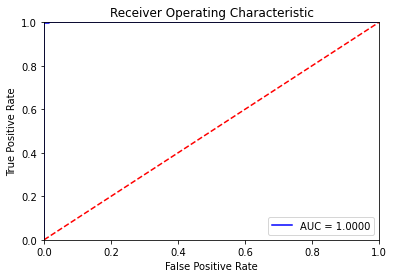

In [ ]:
# call the saved weights
PATH = SAVED_MODEL_PATH+'toy_dataset_bert_model.pt'
model, _, _ = initialize_model(train_loader,epochs=2)
model.load_state_dict(torch.load(PATH))

# Compute predicted probabilities on the validation set
probs_toy = bert_predict(model, val_loader)

# Evaluate ROC-AUC
evaluate_roc(probs_toy, y_val_toy)

### Short Text Dataset

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.665747   |     -      |     -     |   15.36  
   1    |   40    |   0.627315   |     -      |     -     |   14.64  
   1    |   60    |   0.579576   |     -      |     -     |   14.17  
   1    |   80    |   0.558049   |     -      |     -     |   13.91  
   1    |   83    |   0.548570   |     -      |     -     |   1.68   
----------------------------------------------------------------------
   1    |    -    |   0.606252   |  0.504749  |   73.72   |   64.91  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.357882   |     -      |     -     |   14.69  
   2    |   40    |   0.349090   |     -      |     -     |   14.

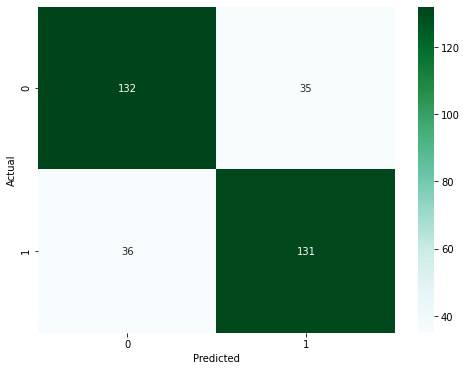

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 16

# load the data
train_loader, val_loader, y_val_short = create_data_loader(root=DATA_PATH,
                                                     train_filename='emotion_classification_cleaned_short_text_train.csv',
                                                     dev_filename='emotion_classification_cleaned_short_text_dev.csv',
                                                     batch_size=batch_size)

#set_seed(42)
# initalise the model
bert_classifier, optimizer, scheduler = initialize_model(train_loader,epochs=2)

# train the model
true_list, pred_list = train(model=bert_classifier,
                             root_path=SAVED_MODEL_PATH,
                             filepath='short_text_dataset_bert_model.pt',
                             train_dataloader=train_loader, 
                             val_dataloader=val_loader, 
                             epochs=2, 
                             evaluation=True)

# get confusion matrix
f1_confusion_matrix(true_list, pred_list)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AUC: 0.8726
Accuracy: 78.74%

ROC Curve


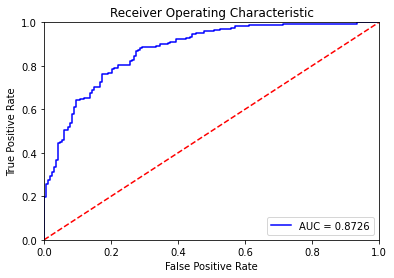

In [ ]:
# call the saved weights
PATH = SAVED_MODEL_PATH+'short_text_dataset_bert_model.pt'
model, _, _ = initialize_model(train_loader,epochs=2)
model.load_state_dict(torch.load(PATH))

# Compute predicted probabilities on the validation set
probs_short = bert_predict(model, val_loader)

# Evaluate ROC-AUC
evaluate_roc(probs_short, y_val_short)

### Long Text Dataset

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.637899   |     -      |     -     |   15.15  
   1    |   40    |   0.442705   |     -      |     -     |   14.98  
   1    |   60    |   0.443128   |     -      |     -     |   15.11  
   1    |   80    |   0.390789   |     -      |     -     |   14.68  
   1    |   100   |   0.246860   |     -      |     -     |   14.44  
   1    |   120   |   0.346943   |     -      |     -     |   14.35  
   1    |   128   |   0.323132   |     -      |     -     |   5.49   
----------------------------------------------------------------------
   1    |    -    |   0.413872   |  0.396484  |   83.02   |  102.34  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------------

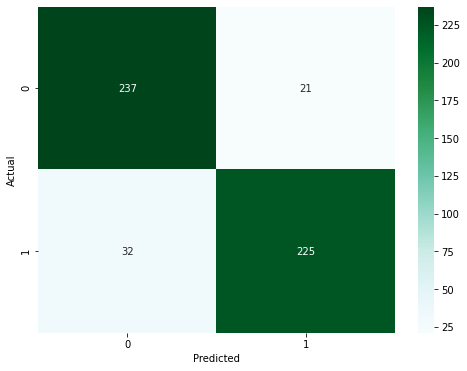

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 16

# load the data
train_loader, val_loader, y_val_long = create_data_loader(root=DATA_PATH,
                                                     train_filename='emotion_classification_cleaned_long_text_train.csv',
                                                     dev_filename='emotion_classification_cleaned_long_text_dev.csv',
                                                     batch_size=batch_size)

# initalise the model
bert_classifier, optimizer, scheduler = initialize_model(train_loader,epochs=2)

# train the model
true_list, pred_list = train(model=bert_classifier,
                             root_path=SAVED_MODEL_PATH,
                             filepath='long_text_dataset_bert_model.pt',
                             train_dataloader=train_loader, 
                             val_dataloader=val_loader, 
                             epochs=2, 
                             evaluation=True)

# get confusion matrix
f1_confusion_matrix(true_list, pred_list)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AUC: 0.9500
Accuracy: 89.71%

ROC Curve


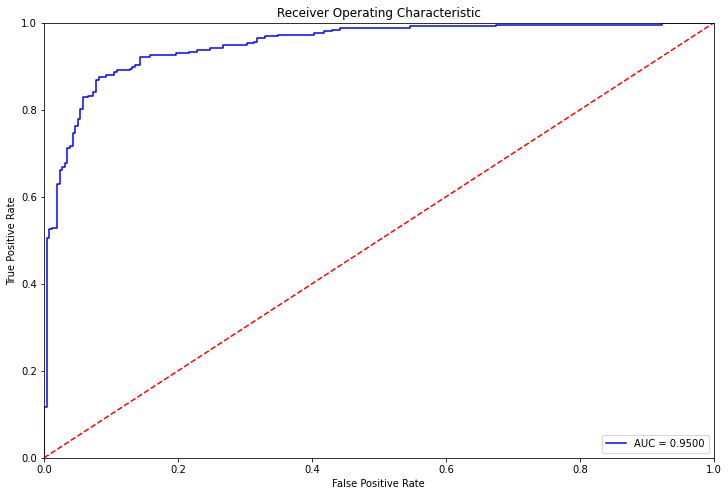

In [ ]:
# call the saved weights
PATH = SAVED_MODEL_PATH+'long_text_dataset_bert_model.pt'
model, _, _ = initialize_model(train_loader,epochs=2)
model.load_state_dict(torch.load(PATH))

# Compute predicted probabilities on the validation set
probs_long = bert_predict(model, val_loader)

# Evaluate ROC-AUC
evaluate_roc(probs_long, y_val_long)

### Mixed Dataset

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.660132   |     -      |     -     |   15.73  
   1    |   40    |   0.606425   |     -      |     -     |   14.98  
   1    |   60    |   0.561048   |     -      |     -     |   14.46  
   1    |   80    |   0.476470   |     -      |     -     |   14.18  
   1    |   100   |   0.482995   |     -      |     -     |   14.16  
   1    |   120   |   0.447869   |     -      |     -     |   14.35  
   1    |   140   |   0.377290   |     -      |     -     |   14.53  
   1    |   160   |   0.388193   |     -      |     -     |   14.60  
   1    |   180   |   0.400098   |     -      |     -     |   14.49  
   1    |   200   |   0.398284   |     -      |     -     |   14.37  
   1    |   211   |   0.377227   |     -      |     -     |   7.85   
----------------------------------------------------------------------

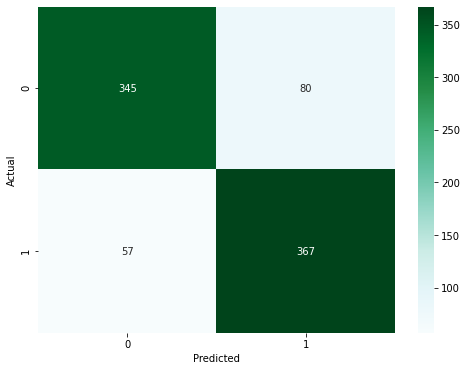

In [ ]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 16

# load the data
train_loader, val_loader, y_val_mixed = create_data_loader(root=DATA_PATH,
                                                     train_filename='emotion_classification_cleaned_combined_text_train.csv',
                                                     dev_filename='emotion_classification_cleaned_combined_text_dev.csv',
                                                     batch_size=batch_size)

#set_seed(42)
# initalise the model
bert_classifier, optimizer, scheduler = initialize_model(train_loader,epochs=2)

# train the model
true_list, pred_list = train(model=bert_classifier,
                             root_path=SAVED_MODEL_PATH,
                             filepath='combined_text_dataset_bert_model.pt',
                             train_dataloader=train_loader, 
                             val_dataloader=val_loader, 
                             epochs=2, 
                             evaluation=True)

# get confusion matrix
f1_confusion_matrix(true_list, pred_list)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AUC: 0.9061
Accuracy: 82.33%

ROC Curve


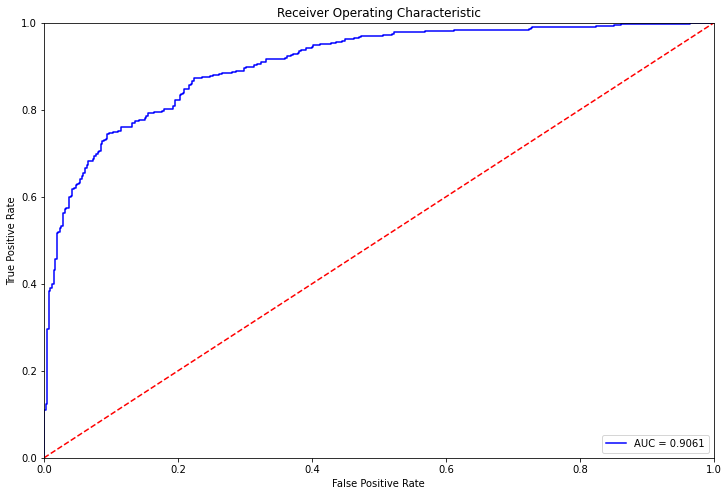

In [ ]:
# call the saved weights
PATH = SAVED_MODEL_PATH+'combined_text_dataset_bert_model.pt'
model, _, _ = initialize_model(train_loader,epochs=2)
model.load_state_dict(torch.load(PATH))

# Compute predicted probabilities on the validation set
probs_mixed = bert_predict(model, val_loader)

# Evaluate ROC-AUC
evaluate_roc(probs_mixed, y_val_mixed)

ROC Curve


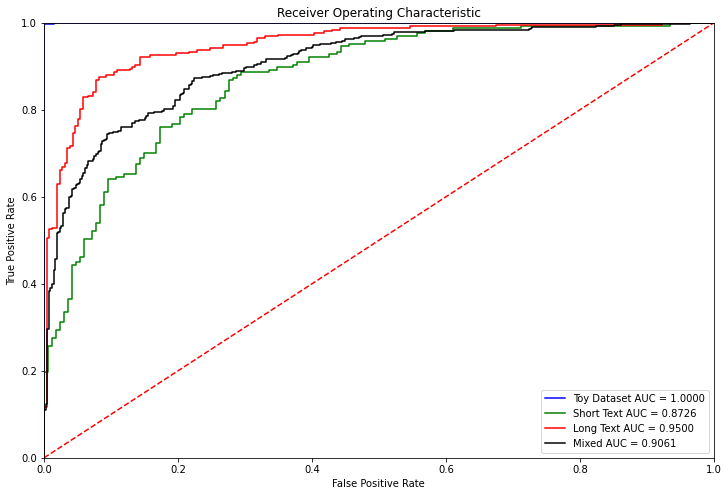

In [ ]:
# get all the ROC curve in a plot
probs_list = [probs_toy, probs_short, probs_long, probs_mixed]
y_val_list = [y_val_toy, y_val_short, y_val_long, y_val_mixed]
evaluate_roc_multi(probs_list, y_val_list)